In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, 
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# importing Random Forest classifier
from sklearn.ensemble import RandomForestClassifier


import os
from pathlib import Path
import time
from collections import OrderedDict, namedtuple

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [3]:
if IN_COLAB:

    from google.colab import drive
    drive.mount('/drive', force_remount=True)
    datadir = '/drive/My Drive/Colab Notebooks/Datasets/'
    optim_dir = datadir + '/optim_dir/'
    results_folder = datadir+'/results/UCI/'
    Path(results_folder).mkdir(parents=True, exist_ok=True)
    Path(optim_dir).mkdir(parents=True, exist_ok=True)
else:
  results_folder = 'results'
  optim_dir = 'optim_dir'
  Path("results").mkdir(parents=True, exist_ok=True)
  Path(optim_dir).mkdir(parents=True, exist_ok=True)


# from opfunu.cec_basic.cec2014_nobias import *
# from mealpy.swarm_based.PSO import BasePSO

Mounted at /drive


In [4]:
import sys

!pip install category_encoders
import category_encoders as ce

if IN_COLAB:
  
  scripts_dir = '/drive/My Drive/Colab Notebooks/scripts/'
  sys.path.insert(1, scripts_dir)
# from opfunu.cec_basic.cec2014_nobias import *
# from mealpy.swarm_based.PSO import BasePSO

# insert at 1, 0 is the script path (or '' in REPL)
else:
    sys.path.insert(1, 'scripts')
from geneticalgorithm import geneticalgorithm as ga
import pickle

     |████████████████████████████████| 81kB 8.6MB/s 


In [5]:
# Enable GPU processing
# if IN_COLAB:
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# else:
#     device = torch.device("cpu")
# print(f'Device type: {device}')

In [6]:
# Set random seed
seed = 777
# torch.manual_seed(seed)
model = None

In [7]:
import random
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    # tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(seed)

seeding done!!!


In [8]:
df = pd.read_csv(f"{datadir}UCI/Letter/data.csv")

In [9]:
df.head()

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [10]:
df.shape

(20000, 17)

In [11]:
x = df.drop(['letter'], axis=1)
y = df['letter']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42) # Split dataset into train and test sets

In [13]:
X_train.shape, X_test.shape # Get the dimensions of features

((16000, 16), (4000, 16))

In [14]:
X_train.head()

,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
5894,4,7,5,5,4,6,7,3,7,11,8,9,3,8,4,8
3728,4,7,6,5,5,6,8,3,7,11,8,9,3,8,4,7
8958,3,5,4,3,3,7,8,5,5,7,7,6,5,9,2,6
7671,4,10,6,7,6,5,7,5,7,6,6,12,3,8,6,9
5999,4,10,6,8,4,8,11,2,3,4,10,9,3,11,1,8


In [15]:
# Create a class to manage the training / hyperparameter runs
class RunManager():
  def __init__(self):
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    
    #---
    self.results = None

  def begin_run(self, run):
    self.run_params = run
    self.run_count += 1
    

  def end_run(self, train_accuracy, test_accuracy):
    # self.epoch_count = 0
    # train_accuracy = 
    # test_accuracy = 

    print(f'run_params: {self.run_params} Train Acc: {train_accuracy} Test Acc: {test_accuracy}')

    results = OrderedDict()
    results['run'] = self.run_count
    results['train acc'] = train_accuracy
    results['test acc'] = test_accuracy
    
    # ---
    self.results = results

    for k, v in self.run_params.items():
      results[k] = v

    self.run_data.append(results)

  def save_output(self, filename):
    if filename:
      filename = filename
      pd.DataFrame.from_dict(self.run_data, orient='columns').to_csv(f'{filename}.csv')
      
      # with open(f'{filename}.json', 'w', encoding='utf-8') as f:
      #   json.dump(self.run_data, f, ensure_ascii=False, indent=4)

      # print('Results saved to disk')

    return pd.DataFrame.from_dict(self.run_data, orient='columns')


In [16]:
# Define training loop execution
def execution_loop(m, args): # args is given by the optimizer
    agent = {}
    agents = []
    
    agent['n'] = args[0].astype(int)
    agent['m'] = int(args[1])
    agents.append(agent)
#     m = RunManager()
    for run in agents: # this should be one. a particle in pso

        # print(f'Run Params: {run}')

        m.begin_run(run)

        num_predictors = X_train.shape[1]
        if run['m'] <= num_predictors:

          rfc = RandomForestClassifier(n_estimators=run['n'], max_features=run['m'], random_state=0)
          rfc.fit(X_train, y_train)

          y_pred_train = rfc.predict(X_train)
          y_pred_test = rfc.predict(X_test)

          train_score = accuracy_score(y_train, y_pred_train)
          test_score = accuracy_score(y_test, y_pred_test)
        else:
          train_score = 0
          test_score = 0

        m.end_run(train_score, test_score)
    return m.results['test acc']

In [17]:
# Define training run hyperparameters
params = {
    'n' : [1, 200],
    'm' : [1, 20]
}

# params = OrderedDict(
#     lr = [0, 1],
#     batch_size = [20 2000],
#     n_epochs = [3]
# )

In [18]:
m = RunManager()
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = f'Run_Results-UCI-Letter-GA-{timestr}'
# filename = 'Run_Results-PSO-20210504-035642-cont.csv' # this is for trying to continue from last optim save


In [19]:
def run_train_model(agent):
    test_acc = execution_loop(m, agent)
    m.save_output(f'{results_folder}/{filename}')
    print("test acc: ", test_acc)
    return test_acc * -1

run_params: {'n': 31, 'm': 6} Train Acc: 1.0 Test Acc: 0.95775
test acc:  0.95775
run_params: {'n': 13, 'm': 9} Train Acc: 0.99975 Test Acc: 0.94375
test acc:  0.94375
run_params: {'n': 167, 'm': 18} Train Acc: 0 Test Acc: 0
test acc:  0
run_params: {'n': 145, 'm': 15} Train Acc: 1.0 Test Acc: 0.94125
test acc:  0.94125
run_params: {'n': 54, 'm': 13} Train Acc: 1.0 Test Acc: 0.946
test acc:  0.946
run_params: {'n': 19, 'm': 2} Train Acc: 1.0 Test Acc: 0.946
test acc:  0.946
run_params: {'n': 118, 'm': 7} Train Acc: 1.0 Test Acc: 0.9595
test acc:  0.9595
run_params: {'n': 197, 'm': 12} Train Acc: 1.0 Test Acc: 0.952
test acc:  0.952
run_params: {'n': 136, 'm': 11} Train Acc: 1.0 Test Acc: 0.95425
test acc:  0.95425
run_params: {'n': 54, 'm': 8} Train Acc: 1.0 Test Acc: 0.954
test acc:  0.954
run_params: {'n': 45, 'm': 4} Train Acc: 1.0 Test Acc: 0.961
test acc:  0.961
run_params: {'n': 78, 'm': 4} Train Acc: 1.0 Test Acc: 0.9635
test acc:  0.9635
run_params: {'n': 122, 'm': 17} Train Ac

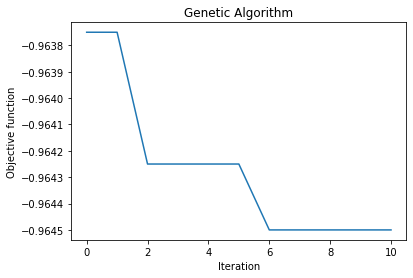

Time to execute: 427.8096 seconds


NameError: ignored

In [20]:
verbose = True
pop_size = 15   
max_iter = 10

obj_func = run_train_model

lb = [params['n'][0], params['m'][0]]
ub = [params['n'][1], params['m'][1]]

algorithm_param = {'max_num_iteration': max_iter,\
                   'population_size':pop_size,\
                   'mutation_probability':0.3,\
                   'elit_ratio': 0.1,\
                   'crossover_probability': 0.6,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

varbound = np.array([ [ lb[0], ub[0] ], [ lb[1], ub[1] ] ] )

tic = time.perf_counter() # Start time counter
model=ga(function=obj_func,dimension=2,variable_type='real',variable_boundaries=varbound, algorithm_parameters=algorithm_param, function_timeout=1000)
model.run(f"{optim_dir}/ga_data-UCI-GA-{timestr}.data")

toc = time.perf_counter() # End time counter
print(f'Time to execute: {toc - tic:0.4f} seconds')
print(f'Best Position: {[int(x) for x in best_pos1]} Best Solution: {best_fit1:0.5f}')

# m.save_output(f'{results_folder}/{filename}')
# print('Results saved.')
